<a href="https://colab.research.google.com/github/RaviChandraVeeramachaneni/fastbook_myexperiments/blob/main/chapter_4/chap_4_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 14.3MB/s 
     |████████████████████████████████| 1.2MB 24.3MB/s 
     |████████████████████████████████| 194kB 50.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
Mounted at /content/gdrive


In [4]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

### Downloading the MNIST Dataset

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/root/.fastai/data/mnist_sample')

In [6]:
Path.BASE_PATH = path

### View the list of downloaded files using ls() from fastai lib

In [7]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

### What's inside a Train set

In [8]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

#### *Check Step: 2 cells: Checking the dataset whether we have everything right for 2 folders 3's & 7's - Not necessary for the actual baseline.*

In [9]:
threes = (path/'train'/'3').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [10]:
sevens = (path/'train'/'7').ls().sorted()
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

### Checking an image: 2 cells: 3 & 7 

In [11]:
img3_path = threes[1]
img3 = Image.open(img3_path)
img3

In [12]:
img7_path = sevens[5]
img7 = Image.open(img7_path)
img7

In [13]:
type(img7)

PIL.PngImagePlugin.PngImageFile

#### Image under the hood in a computer. 
    - Represting the image in a Numpy array in the form of rows & cols



In [14]:
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [15]:
type(array(img3))

numpy.ndarray

In [16]:
np.ndim(array(img3))

2

#### Image under the hood in a computer.
    - Represting the image in a PyTorch tensor in the form of rows & cols

In [17]:
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [18]:
type(tensor(img3))

torch.Tensor

In [19]:
tensor(img3).ndim

2

### Importing Pandas lib

### Check the array output using some cool functions from Pandas & color coding it check the results.

In [20]:
img3_t = tensor(img3)
df = pd.DataFrame(img3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Simple Baseline approach for classifying the Images

### Step1: Calculating average of pixel values for each of our two groups
    - To do this we need to stack all the relative images using tensors & simple python lists

In [21]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [22]:
type(seven_tensors)

list

### Check one of the image using fastai show_image function

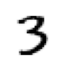

In [23]:
show_image(three_tensors[1])

### Stacking list of image tensors to create a rank-3 tensor which will allow us take the mean. 

In [24]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [25]:
type(stacked_sevens)

torch.Tensor

### Rank of a tensor

In [26]:
stacked_sevens.ndim

3

### Shape of a tensor

In [27]:
len(stacked_threes.shape)

3

### Calculating the mean of the image tensors along dimension-0 of our stacked rank-3 tensor for Image 3
    - for every pixel position, this will compute the average of that pixel over all the images.

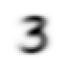

In [28]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

### The result is a 2-dimensional tensor or a ideal image of 3 in this case.

In [29]:
mean3.ndim

2

In [31]:
type(mean3)

torch.Tensor

### Calculating the mean of the image tensors along dimension-0 of our stacked rank-3 tensor for Image 7
    - for every pixel position, this will compute the average of that pixel over all the images.

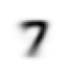

In [32]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

### Pick any 3 from the stacked 3's

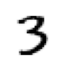

In [33]:
any_3 = stacked_threes[1]
show_image(any_3)

### Using L1 norm
    - To calculate the difference between the image to classify vs the ideal image.

#### Computing: L1 norm & L2 norm for a 3 & 7 using ideal 3 just to check the difference.
---
#### Result: The result would be that the difference of any 7 and a ideal 3 is very far & in case of any 3 it's very close in both L1 & L2.

In [34]:
dist_3_abs = (any_3 - mean3).abs().mean()
dist_3_sqr = ((any_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [35]:
dist_7_abs = (any_3 - mean7).abs().mean()
dist_7_sqr = ((any_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

### Checking the loss in the above cases using PyTorch functions.
    - The above models are also available directly in PyTorch in torch.nn.functional package
    - These models are by default imported in fastai as F as recommended by PyTorch lib.

In [36]:
F.l1_loss(any_3.float(),mean7), F.mse_loss(any_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### Computing the metrics/Using the created model to test the quality of our model with validation set

#### Stacking the images of 3's & 7's from validation set

In [37]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [38]:
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_7_tens.shape

torch.Size([1028, 28, 28])

#### function to determine the distance betweeb two tensors

In [39]:
def mnist_distance(a,b): 
    return (a-b).abs().mean((-1,-2))

#### Test the function by passing any image of 3 & a ideal 3

In [40]:
mnist_distance(any_3, mean3)

tensor(0.1114)

#### Compute: Distance to ideal 3 for every image to get overall accuracy.
---
 - Result: Rank-1 tesnor with distance of every single image as a vector.

In [41]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1221, 0.1152, 0.1445,  ..., 0.1383, 0.1053, 0.1258]),
 torch.Size([1010]))

#### Checking the shape stacked 3's in validation set 
---
 - Result: Mean3 value is bradcasted & subtarcted from each tensor in the valid_3_tens

In [42]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

#### function to determine whether given image is 3 or not.

In [43]:
def is_3(x): 
    return mnist_distance(x,mean3) < mnist_distance(x,mean7)

#### Test the function with a sample 3 image

In [44]:
is_3(any_3), is_3(any_3).float()

(tensor(True), tensor(1.))

#### Testing the full validation set of 3's using broadcasting technique

In [45]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True,  True, False])

#### Calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s

In [46]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [48]:
print(f'Accuracy of a given image being a 3 is {accuracy_3s}')

Accuracy of a given image being a 3 is 0.9168316721916199


In [49]:
print(f'Accuracy of a given image being a 7 is {accuracy_7s}')

Accuracy of a given image being a 7 is 0.9854085445404053


In [50]:
print(f'The overall accuracy of a given image being either a 3 or 7 is {(accuracy_3s+accuracy_7s)/2}')

The overall accuracy of a given image being either a 3 or 7 is 0.951120138168335


In [51]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [52]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [53]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [54]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [55]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

In [65]:
weights = init_params((28*28,1))

In [66]:
bias = init_params(1)

In [67]:
(train_x[0]*weights.T).sum() + bias

tensor([14.0882], grad_fn=<AddBackward0>)

In [68]:
def linear1(xb): 
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[14.0882],
        [13.9915],
        [16.0442],
        ...,
        [ 1.2085],
        [ 1.7146],
        [ 2.6879]], grad_fn=<AddBackward0>)

In [69]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [70]:
corrects.float().mean().item()

0.5766376256942749

In [72]:
with torch.no_grad():
         weights[0] *= 1.0001

In [73]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5642949342727661

In [74]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [75]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [76]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [77]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [78]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

In [79]:
def sigmoid(x): 
    return 1/(1+torch.exp(-x))

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


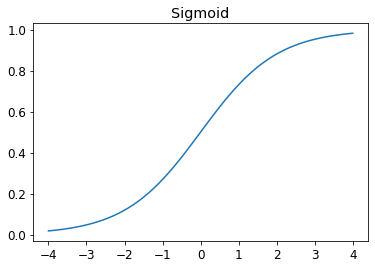

In [80]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [81]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [82]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [83]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [84]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

In [85]:
weights = init_params((28*28,1))
bias = init_params(1)

In [86]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [87]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [88]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [89]:
preds = linear1(batch)
preds

tensor([[-11.2639],
        [  8.6354],
        [  9.7702],
        [  6.5796]], grad_fn=<AddBackward0>)

In [90]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.2504, grad_fn=<MeanBackward0>)

In [91]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-6.9700e-05), tensor([-0.0004]))

In [92]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [93]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0001), tensor([-0.0008]))

In [94]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0002), tensor([-0.0012]))

In [95]:
weights.grad.zero_()
bias.grad.zero_();

In [96]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [97]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [ True],
        [ True]])

In [98]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [99]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [100]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [101]:
validate_epoch(linear1)

0.6276

In [102]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.707

In [103]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8539 0.9081 0.9291 0.9364 0.9442 0.9481 0.954 0.9589 0.9608 0.9623 0.9633 0.9662 0.9667 0.9682 0.9682 0.9687 0.9687 0.9691 0.9701 0.9701 

In [104]:
linear_model = nn.Linear(28*28,1)

In [105]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [106]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [107]:
opt = BasicOptim(linear_model.parameters(), lr)

In [108]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [109]:
validate_epoch(linear_model)

0.4912

In [110]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [111]:
train_model(linear_model, 20)

0.4932 0.5036 0.6909 0.8828 0.9209 0.9385 0.9521 0.959 0.9643 0.9658 0.9687 0.9707 0.9726 0.9746 0.9756 0.9761 0.977 0.9775 0.978 0.978 

In [112]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8428 0.833 0.9106 0.9316 0.9472 0.9546 0.9629 0.9653 0.9668 0.9692 0.9721 0.9721 0.9746 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

In [113]:
dls = DataLoaders(dl, valid_dl)

In [114]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [115]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636880,0.503240,0.495584,00:00
1,0.444859,0.250160,0.775270,00:00
2,0.166588,0.161544,0.853778,00:00
3,0.074712,0.100249,0.916585,00:00
4,0.040760,0.074722,0.934740,00:00
5,0.027436,0.060469,0.947498,00:00
6,0.021918,0.051475,0.956330,00:00
7,0.019425,0.045455,0.962709,00:00
8,0.018127,0.041207,0.965653,00:00
9,0.017327,0.038063,0.968106,00:00


In [116]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [117]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

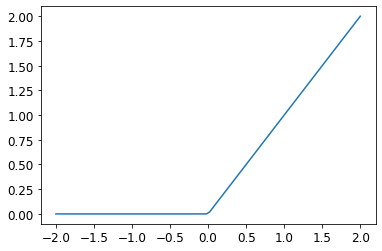

In [118]:
plot_function(F.relu)

In [119]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [120]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [121]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.295725,0.410642,0.505397,00:00
1,0.140343,0.228126,0.805201,00:00
2,0.078806,0.116279,0.912169,00:00
3,0.052364,0.078734,0.939156,00:00
4,0.039967,0.061383,0.954367,00:00
5,0.033558,0.051578,0.964671,00:00
6,0.029834,0.045389,0.965653,00:00
7,0.027392,0.041166,0.967125,00:00
8,0.025620,0.038107,0.969578,00:00
9,0.024242,0.035778,0.970559,00:00


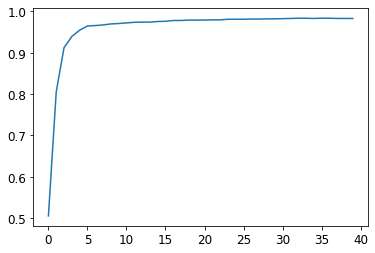

In [122]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [123]:
learn.recorder.values[-1][2]

0.982826292514801

In [124]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.109769,0.026043,0.994603,00:08
